# ChatBot Model Using Machine Learning and Deep Learning

- Here the approch is to use machine learing and Nlp to build the chatbot model.
- Actually, Machine learning is Great approach to build a Chatbot with small amount of data.
- Machine learning model take small amount of time to train and work well with small and to the point dataset.
- Dialogflow(Google Service) also use Machine learning to build customized Chatbot for Business.
- We use different Machine learning model for chatbot and choose the best compitable model.
- we use banking frequently asked question as chatbot dataset.

## Importing the Library

In [1]:
import pandas as pd
import numpy as np
import pickle
import operator
import random

### Importing the dataset

In [2]:
data = pd.read_csv('C:\\Users\\SAMEER\\Downloads\\banking-faq-bot-master\\BankFAQs.csv',error_bad_lines= False)
questions = data['Question'].values

In [3]:
data.head()

,Question,Answer,Class
0,Do I need to enter ‘#’ after keying in my Card...,Please listen to the recorded message and foll...,security
1,What details are required when I want to perfo...,"To perform a secure IVR transaction, you will ...",security
2,How should I get the IVR Password if I hold a...,An IVR password can be requested only from the...,security
3,How do I register my Mobile number for IVR Pas...,Please call our Customer Service Centre and en...,security
4,How can I obtain an IVR Password,By Sending SMS request: Send an SMS 'PWD<space...,security


In [4]:
import nltk
from nltk.stem.lancaster import LancasterStemmer

### stemming is the process of reducing words to their word base or root form

In [5]:
stemmer = LancasterStemmer()
def cleanup(sentence):
    word_tok = nltk.word_tokenize(sentence)
    stemmed_words = [stemmer.stem(w) for w in word_tok]

    return ' '.join(stemmed_words)

In [6]:
X = []
for question in questions:
    X.append(cleanup(question))

In [7]:
X[:5]

['do i nee to ent ‘ # ’ aft key in my card number/ card expiry date/ cvv numb',
 'what detail ar requir when i want to perform a sec ivr transact',
 'how should i get the ivr password if i hold an add-on card',
 'how do i reg my mobl numb for ivr password',
 'how can i obtain an ivr password']

## using Tfidf from sklearn

-  TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how     important a word is to a document in a collection or corpus.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=1, stop_words='english')
tfidf.fit(X)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

### Using label encoder for converting the word to code

In [9]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(data['Class'])

LabelEncoder()

In [10]:
X = tfidf.transform(X)
Y = encoder.transform(data['Class'])

## Spliting the dataset

In [11]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=.25, random_state=0)

## Here we apply different Machine learning Model 

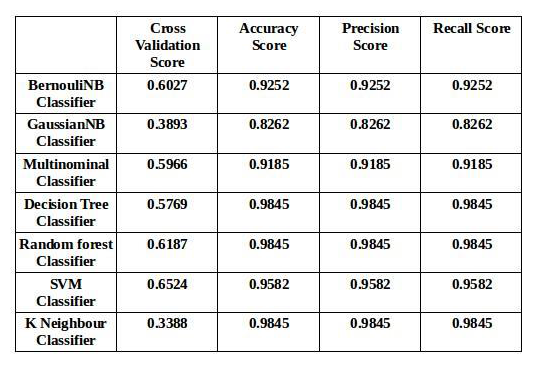

### The most compitable Model is Random Forest And SVM.

## Applying the SVM model

In [12]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(train_x, train_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
print("SVC: ", model.score(test_x, test_y))

SVC:  0.9410430839002267


## Finding the top 5 question related to user typed question

Actually some time user ask something that Bot didn't understand.
For that Bot, show the user asked relevant Question and User picked from them.

In [14]:
def get_max5(arr):
    ixarr = []
    for ix, el in enumerate(arr):
        ixarr.append((el, ix))
    ixarr.sort()

    ixs = []
    for i in ixarr[-5:]:
        ixs.append(i[1])

    return ixs[::-1]

## Main function to process our chat

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
def chat():
    cnt = 0
    TOP5 = False
    print("PRESS Q to QUIT")
    print("Bot: Hi, Welcome to our bank! How may help you???")
    while True:
        usr = input("You: ")

        if usr.lower() == 'yes':
            print("Bot: Yes!")
            continue

        if usr.lower() == 'no':
            print("Bot: No?")
            continue
            
        if usr == 'Q':
            print("Bot: Thank You!!! It was good to be of help.")
            break

        if usr == 'TOP5':
            TOP5 = True
            print("Will display 5 most relevent results now")
            continue


        t_usr = tfidf.transform([cleanup(usr.strip().lower())])
        class_ = encoder.inverse_transform(model.predict(t_usr)[0])
        questionset = data[data['Class']==class_]
        
        cos_sims = []
        for question in questionset['Question']:
            sims = cosine_similarity(tfidf.transform([question]), t_usr)
            cos_sims.append(sims)
            
        ind = cos_sims.index(max(cos_sims))

        if not TOP5:
            print("Bot:", data['Answer'][questionset.index[ind]])
        else:
            inds = get_max5(cos_sims)
            for ix in inds:
                print("Question: "+data['Question'][questionset.index[ix]])
                print("Answer: "+data['Answer'][questionset.index[ix]])
                print('-'*50)

        print("\n"*2)
        outcome = input("Was this answer helpful? Yes/No: ").lower().strip()
        if outcome == 'yes':
            cnt = 0
        elif outcome == 'no':
            inds = get_max5(cos_sims)
            sugg_choice = input("Bot: Do you want me to suggest you questions ? Yes/No: ").lower()
            if sugg_choice == 'yes':
                q_cnt = 1
                for ix in inds:
                    print(q_cnt,"Question: "+data['Question'][questionset.index[ix]])
                    print('-'*50)
                    q_cnt += 1
                num = int(input("Please enter the question number you find most relevant or, 0 for none: "))
                if num == 0:
                    continue
                else:
                    print("Bot: ", data['Answer'][questionset.index[inds[num-1]]])


In [16]:
chat()

PRESS Q to QUIT
Bot: Hi, Welcome to our bank! How may help you???
You: account opening


C:\Users\SAMEER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Bot: Payment outside India towards a permissible current account transaction [in accordance to the provisions of the Foreign Exchange Management (Current Account Transactions) Rules, 2000] and permissible capital account transaction [in accordance to the Foreign Exchange Management (Permissible Capital Account Transactions) Regulations, 2000]. Payment in foreign exchange towards cost of goods purchased from a 100 percent export oriented unit or a unit in (a) Export Processing Zone or (b) Software Technology Park or (c) Electronic Hardware Technology Park. Payment of customs duty in accordance with the provisions of the Foreign Trade Policy of the Central Government for the time being in force. Trade related loans/advances, extended by an exporter holding such account to his importer customer outside India, subject to compliance with the Foreign Exchange Management (Borrowing and Lending in Foreign Exchange) Regulations, 2000. Payment in foreign exchange to a person resident in India fo

C:\Users\SAMEER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Bot: You have to login to NetSafe on the HDFC bank website using your login id & Verified by Visa/ MasterCard SecureCode password. Once you login to Netsafe click on reregister cards, enter your date of birth and CVV2 and post that the card will be reregistered. You can now use the card for online transaction.



Was this answer helpful? Yes/No: yes
You: repay my loan


C:\Users\SAMEER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Bot: You pay the loan in equal monthly instalments (EMIs). The loan will be paid through post-dated cheques. You can also pay through Electronic Clearing System (ECS ) or a standing instruction to debit your HDFC Bank account with the EMI amount



Was this answer helpful? Yes/No: yes
You: yes
Bot: Yes!
You: how much i can get the loan


C:\Users\SAMEER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Bot: You can repay your loan over a period of 12 to 48 months



Was this answer helpful? Yes/No: no
Bot: Do you want me to suggest you questions ? Yes/No: yes
1 Question: What is the maximum loan amount I can take on a Tractor Loan
--------------------------------------------------
2 Question: Who is eligible for a tractor loan
--------------------------------------------------
3 Question: Is part-prepayment of a Personal Loan allowed
--------------------------------------------------
4 Question: What are the loan tenure options for Professionals Loan
--------------------------------------------------
5 Question: Are there any additional charges for loan Prepayment
--------------------------------------------------
Please enter the question number you find most relevant or, 0 for none: 1
Bot:  You can borrow up to 90%, subject to credit underwriting standards of the bank.
You: guarantor


C:\Users\SAMEER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Bot: To obtain the loan, there is absolutely no need to provide any security or collateral.



Was this answer helpful? Yes/No: yes
You: what is neft


C:\Users\SAMEER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Bot: The National Electronic Funds Transfer (NEFT) system is a nation-wide funds transfer system to facilitate transfer of funds from any bank branch to any other bank branch.



Was this answer helpful? Yes/No: yes
You: yes
Bot: Yes!
You: when do i start paying my emi


C:\Users\SAMEER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Bot: In case you wish to foreclose your Loan Against Property, the foreclosure charges are applicable on the outstanding principal or Outstanding Limit as the case may be.(Pre-payment is allowed only after 6 months from the date of loan disbursement).



Was this answer helpful? Yes/No: no
Bot: Do you want me to suggest you questions ? Yes/No: yes
1 Question: What are the charges I need to pay to foreclose my Loans Against Rental Receivable
--------------------------------------------------
2 Question: What are the charges I need to pay to foreclose my loan
--------------------------------------------------
3 Question: When do I start paying my EMI
--------------------------------------------------
4 Question: Do I have the option to pre-pay the entire loan amount
--------------------------------------------------
5 Question: Can I pre-pay the entire loan amount
--------------------------------------------------
Please enter the question number you find most relevant or, 0 for none: 3


## Thank you